# Goal

We evaluate a repopulation by looking at the correlation between repopulation values and average birds per checklist at various locations. 

We have non-uniform information on locations. 

For some locations, there are many checklists, and we can compute birds per checklist accurately. For other locations, we have only one or two checklists. 

On the other hand, locations with many checklists are often in disturbed terrain: it's terrain that is accessible to humans and often disturbed by their frequent presence (e.g., close to car access, many visitors, etc).  Further, locations are affected by "location noise" due to their own circumstances: fluctuations in nutrient density, birder access (the predominant bird-watching paths may be in various directions, and in different terrain types), birder circumstances (tourist spots vs. stations used by researchers), birder intentions (nearby bodies of water may attract birder's attention more than the surrounting forest).  So there is also location-to-location noise. 

Let: 
* Checklist noise is the noise associated with checklists at the same locations. 
* Location noise is the noise from one location to the other. 

If checklist noise is greater than location noise, we should preferentially use only locations with sufficient checklists (e.g., 10). 

If the two noises are equivalent, we should use all locations, since locations with fewer checklists may correspond to less disturbed locations. 

Here, we evaluate both kinds of noise.


## Code Setup

In [1]:
# If True, assumes everything is running locally.
IS_LOCAL = True

LOCAL_PATH = "data/CA-EcoScape-Paper"
DATA_PATH = LOCAL_PATH

In [2]:
# For this evaluation, you do need a copy of the database.
DB_PATH = "/Users/luca/data/eBird/bird_data_uswest.db"

In [3]:
import os
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt


In [4]:
sys.path.append(os.path.join(os.getcwd(), "birdmaps"))

In [5]:
import ebird_db, bird_runs

## Bird Run Definition

In [12]:

bird_run = bird_runs.BirdRun(DATA_PATH)

birds = []

NUM_SIMULATIONS = 400
NUM_SPREADS = [2, 4, 6, 8, 10, 15, 20, 30, 40]

for hop_distance in range(1, 7):
    for num_spreads in NUM_SPREADS:
        birds.append(bird_run.get_bird_run(
            "acowoo", "Acorn Woodpecker",
            run_name="Jun8",
            hop_distance=hop_distance, num_spreads=num_spreads,
            num_simulations=NUM_SIMULATIONS))

for hop_distance in range(1, 7):
    for num_spreads in NUM_SPREADS:
        birds.append(bird_run.get_bird_run(
            "oaktit308", "Oak Titmouse",
            run_name="Jun8",
            hop_distance=hop_distance, num_spreads=num_spreads,
            num_simulations=NUM_SIMULATIONS))

for hop_distance in range(1, 7):
    for num_spreads in NUM_SPREADS:
        birds.append(bird_run.get_bird_run(
            "stejay", "Steller's Jay",
            run_name="Jun8",
            hop_distance=hop_distance, num_spreads=num_spreads,
            num_simulations=NUM_SIMULATIONS))
    

For a given run, we can read a dataframe contains, for each square, the:
* Number of checklists
* Number of checklists containing the bird
* Total number of birds (of the given species) seen
* average habitat around the square (counting 1 as habitat and 0 as non-habitat)
* max habitat around the square
* average repopulation around the square (counting as 0 out of habitat of course)
* max repopulation around the square.

I look for the correlation between:
* Average number of birds seen (the BirdRatio),
* Max repopulation (MaxRepopRange).

Why max repopulation and not average?  Because average repopulation mixes two concerns: (a) how much habitat there is around, and (b) how high the repopulation is in that habitat.  This confounds the signal.  It is much cleaner to look at the correlation between BirdRatio and MaxRepopRange.

In [13]:
def wmean(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def wcov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - wmean(x, w)) * (y - wmean(y, w))) / np.sum(w)

def wcorr(x, y, w):
    """Weighted Correlation"""
    return wcov(x, y, w) / np.sqrt(wcov(x, x, w) * wcov(y, y, w))

In [14]:
ebird_obs = ebird_db.EbirdObservations(DB_PATH)
max_dist = 2
date_range = ("2012-01-01", "2018-12-31")
breeding = True
bird_run = bird_runs.BirdRun(DATA_PATH)

def analyze_checklist_noise(bird_nickname, hop_distance=2, spreads=2, min_checklists=10):
    """Displays the observation count noise at a location."""
    for bird in birds:
        if bird.nickname == bird_nickname and bird.hop_distance == hop_distance and bird.num_spreads == spreads:
            bird_name = bird.name
            df = pd.read_csv(bird.obs_csv_path)
            # limit to squares where max hab > 0.9
            df = df.loc[lambda r : r["max_hab"] > 0.9]
            # and we have sufficient checklists. 
            df = df.loc[lambda r : r["NumChecklists"] >= min_checklists]
            stdevs = []
            for square in list(df["Square"]):
                checklists_df = ebird_obs.get_square_individual_checklists(
                    square, bird, date_range=date_range, max_dist=max_dist)
                c = checklists_df.loc[lambda r : r["Count"] != "X"]
                stdevs.append(c["Count"].std())
            ddf = pd.DataFrame(stdevs)
            ddf.hist()
            plt.show()
            return ddf 


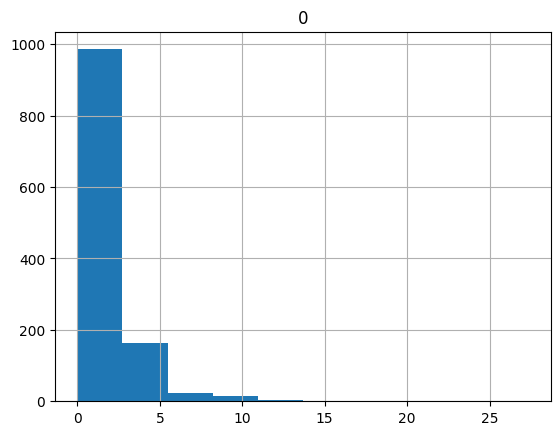

In [16]:
ddf = analyze_checklist_noise("acowoo", hop_distance=2, spreads=20)

In [17]:
print("Checklist average noise:", ddf.mean())

Checklist average noise: 0    1.524287
dtype: float64


In [18]:
print("Checklist median noise:", ddf.median())

Checklist median noise: 0    1.021469
dtype: float64


In [19]:
ebird_obs = ebird_db.EbirdObservations(DB_PATH)
max_dist = 2
date_range = ("2012-01-01", "2018-12-31")
breeding = True

def analyze_location_noise(bird_nickname, hop_distance=2, spreads=2, min_checklists=10):
    for bird in birds:
        if bird.nickname == bird_nickname and bird.hop_distance == hop_distance and bird.num_spreads == spreads:
            bird_name = bird.name
            df = pd.read_csv(bird.obs_csv_path)
            # limit to squares where max hab > 0.9
            df = df.loc[lambda r : r["max_hab"] > 0.9]
            noise = []
            all_weights = []
            df["MaxRepopRange"] = df.apply(lambda row : int(row["max_repop"] * 9.999) / 10, axis=1)
            for num_checklists in range(1, 11):
                fdf = df.loc[lambda r : r["NumChecklists"] == num_checklists]
                stds = fdf.groupby("MaxRepopRange")["BirdRatio"].std()
                weights = fdf.groupby("MaxRepopRange")["BirdRatio"].count()
                noise.append(wmean(stds, weights))
                all_weights.append(weights.sum())
                stds.plot(label=str(num_checklists)) 
                plt.legend()
            plt.show()
            plt.plot(range(1, 11), noise)
            plt.title("Location noise in repopulation ranges")
            plt.show()
            print("Overall location noise:", wmean(np.array(noise), np.array(all_weights)))


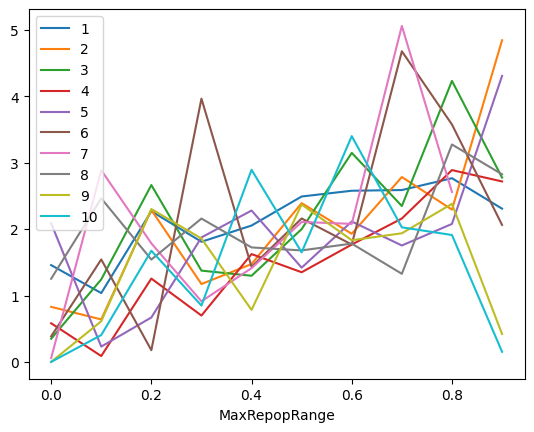

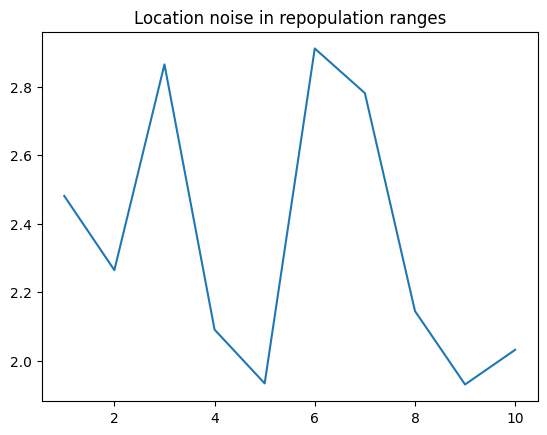

Overall location noise: 2.4173987951732707


In [20]:
df = analyze_location_noise("acowoo", hop_distance=2, spreads=20)